<a href="https://colab.research.google.com/github/kim-jason/Face-Mask-Recognition-ML-Model/blob/main/Face_Mask_Recognition_ML_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mask Detection
### In this notebook, we will implement a mask detector using different methods.


## Download the Dataset

Please note that in general one would create the training set and test set by randomly splitting a single dataset. The two datasets we download are indeed from the same source but are downloaded separately as the test dataset will be used by an autograder later.

In [1]:
# Import several libraries to be used in the notebook

import pickle
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imgaug import augmenters
import random
from sklearn.linear_model import Perceptron
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv1D, MaxPooling1D
from keras.layers import Dense, Activation, Dropout, Flatten

Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
# Download the training dataset of images

!wget "https://drive.google.com/uc?export=download&id=1ouMOxaDNNr-U7E2DD3Y6wLlyeVb8qnr0" -O train_data.p
data_list = pickle.load(open("train_data.p", "rb"))

--2022-10-04 20:46:36--  https://drive.google.com/uc?export=download&id=1ouMOxaDNNr-U7E2DD3Y6wLlyeVb8qnr0
Resolving drive.google.com (drive.google.com)... 74.125.195.113, 74.125.195.101, 74.125.195.102, ...
Connecting to drive.google.com (drive.google.com)|74.125.195.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-a0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/0g5g9fr7nudbv1he1upo7nf94k1l21a5/1664916375000/15787019596848476183/*/1ouMOxaDNNr-U7E2DD3Y6wLlyeVb8qnr0?e=download&uuid=12ab4ade-224c-46c6-be1c-1b109f71aa28 [following]
--2022-10-04 20:46:38--  https://doc-0s-a0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/0g5g9fr7nudbv1he1upo7nf94k1l21a5/1664916375000/15787019596848476183/*/1ouMOxaDNNr-U7E2DD3Y6wLlyeVb8qnr0?e=download&uuid=12ab4ade-224c-46c6-be1c-1b109f71aa28
Resolving doc-0s-a0-docs.googleusercontent.com (doc-0s-a0-docs.googleusercontent.com)... 74.125.195.132, 2607:

In [3]:
# Download the test dataset of images

!wget "https://drive.google.com/uc?export=download&id=16CCS6DiAzFwCT1165ogvKVf9JwajOAHm" -O test_images.p
test_images = pickle.load(open("test_images.p", "rb"))

--2022-10-04 20:46:39--  https://drive.google.com/uc?export=download&id=16CCS6DiAzFwCT1165ogvKVf9JwajOAHm
Resolving drive.google.com (drive.google.com)... 74.125.195.113, 74.125.195.101, 74.125.195.102, ...
Connecting to drive.google.com (drive.google.com)|74.125.195.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-a0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/3svj8s68b0tt7mi2lp24qadh1mi2lq2s/1664916375000/15787019596848476183/*/16CCS6DiAzFwCT1165ogvKVf9JwajOAHm?e=download&uuid=32d6567f-a299-4d7f-a36d-d92ea9d60eb3 [following]
--2022-10-04 20:46:39--  https://doc-0s-a0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/3svj8s68b0tt7mi2lp24qadh1mi2lq2s/1664916375000/15787019596848476183/*/16CCS6DiAzFwCT1165ogvKVf9JwajOAHm?e=download&uuid=32d6567f-a299-4d7f-a36d-d92ea9d60eb3
Resolving doc-0s-a0-docs.googleusercontent.com (doc-0s-a0-docs.googleusercontent.com)... 74.125.195.132, 2607:

### View the dataset

We will check that the training dataset was properly downloaded and marked. The given training dataset contains 4602 examples, with each one containing an image of a human face with a label (good or bad) to denote whether there is a mask on the face.

The size of the dataset is:  4602

 The Structure of the data:  
 <class 'dict'>
{'image': array([[123,  90,  67, ..., 224, 221, 222],
       [ 94,  64,  55, ..., 227, 229, 220],
       [ 69,  51,  47, ..., 230, 232, 226],
       ...,
       [210, 186, 142, ..., 214, 217, 203],
       [225, 212, 221, ..., 221, 198, 194],
       [229, 218, 209, ..., 216, 220, 219]]), 'label': 'bad'}

 Show some of the samples


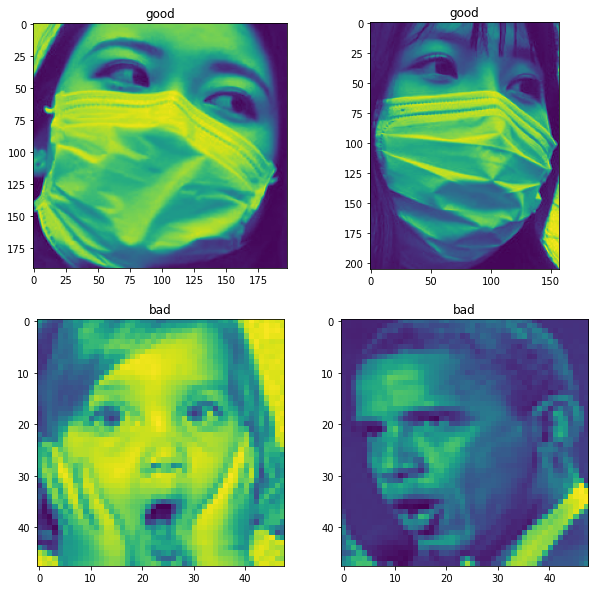

In [4]:
print("The size of the dataset is: ", len(data_list))
print("\n The Structure of the data: ", '\n', type(data_list[0]))
print(data_list[-1])
print("\n Show some of the samples")
f, axarr = plt.subplots(2,2, figsize=(10,10))
axarr[0, 0].imshow(data_list[1]['image'])
axarr[0, 0].title.set_text(data_list[0]['label'])
axarr[0, 1].imshow(data_list[2]['image'])
axarr[0, 1].title.set_text(data_list[2]['label'])
axarr[1, 0].imshow(data_list[-1]['image'])
axarr[1, 0].title.set_text(data_list[-1]['label'])
axarr[1, 1].imshow(data_list[-2]['image'])
axarr[1, 1].title.set_text(data_list[-3]['label'])
f.show()

## Preprocessing of the Dataset

### Distribution of the Dataset

We will check the distribution of labels and sizes of the training dataset's images.

In [5]:
# Check distribution of labels of images

Num_of_classes = 0
classes = {}
for sample in data_list:
  if sample['label'] not in classes:
    classes[sample['label']] = 1
  else:
    classes[sample['label']] += 1
print("Num. of Different Classes: ", classes)

Num. of Different Classes:  {'good': 2397, 'bad': 2205}


In [6]:
# Check distribution of sizes of images

image_size = []
for sample in data_list:
  image_data = sample['image']
  size = image_data.shape[0] * image_data.shape[1]
  image_size.append(size)

In [7]:
print("Median Size of Images: ", np.median(image_size))

Median Size of Images:  2304.0


### Image Preprocessing
For this section, we will preprocess the images according to the following steps:
*   Convert the gray image to RGB
*   Resize the image to 128 * 128
*   Scale the value of each pixel from [0, 255] to [-1, 1]

In [8]:
# Put images and labes into lists

label2int = {"good": 1, "bad": 0}
IMAGES = []
LABELS = []
for sample in data_list:
  IMAGES.append(sample['image'])
  LABELS.append(label2int[sample['label']])

In [9]:
# Preprocess the images

def preprocess(image):

  #Converts the gray-scale (2D) image to RGB (3D)
  image = cv.cvtColor(image.astype(np.uint8), cv.COLOR_GRAY2RGB)
  
  #Resizes the image to (128, 128, 3)
  image = cv.resize(image, (128, 128))

  #Scales the value of each pixel from [0, 255] to [-1, 1] using MinMaxScaler
  scaler = MinMaxScaler(feature_range=(-1,1))
  image = scaler.fit_transform(image.reshape(-1, image.shape[-1])).reshape(image.shape)

  return image

In [10]:
# Process each raw image

processed_IMAGES = []
for image in IMAGES:
  processed_IMAGES.append(preprocess(image))

In [11]:
# Confirm that pixel values have been properly scaled from [0,255] to [-1,1]

test = processed_IMAGES[0]
print(np.max(test)) #Should be 1
print(np.min(test)) #Should be -1

1.0
-0.9999999999999999


## Data Augmentation

We will augment the dataset by generating additional images to use for training purposes. The following code is from a popular [TowardsDataScience article](https://towardsdatascience.com/deeppicar-part-5-lane-following-via-deep-learning-d93acdce6110), which highlights the use of flips, blurs, and zooms to generate more images.

In [12]:
class Augmenter:
  def __init__(self, XData, YData):
    self.XData = XData
    self.YData = YData
    self.run()

  def zoom(self, data):
    def yielder():
      for img in data:
          maxZoomLevel = random.uniform(1.1, 1.5)
          zoom = augmenters.Affine(scale=(1, maxZoomLevel)) 

          yield zoom.augment_image(img) 
          
    return np.array(list(yielder()))
  def flip(self, data):
    def yielder():
      for img in data:
          flipHorz = random.randint(0,1)
          flipVert = random.randint(0,1)
          if flipHorz and flipVert:
            img = cv.flip(img,0)
            yield cv.flip(img, 1)
          elif flipHorz and not flipVert:
            yield cv.flip(img, 0)
          elif not flipHorz and flipVert:
            yield cv.flip(img, 1)
          else:
            img = cv.flip(img,0)
            yield cv.flip(img, 1)

    return np.array(list(yielder()))
  def blur(self, data):
    def yielder():
      for img in data:
        blur = random.randint(0,1) 
        # if blur:
        kernel_size = random.randint(3, 30)
        yield cv.blur(img, (kernel_size,kernel_size))
        # else:
        #   yield img
    return np.array(list(yielder()))

  def run(self):
    Xdat1, Xdat2, Xdat3 = np.array_split(self.XData, 3)
    zoomedXData = self.zoom(Xdat1)
    XData = np.append(self.XData, zoomedXData, axis = 0)
    flippedXData = self.flip(Xdat2)
    XData = np.append(XData, flippedXData, axis = 0)

    blurredXData = self.blur(Xdat3)
    XData = np.append(XData, blurredXData, axis = 0)

    # XData = np.stack((self.XData, zoomedXData, flippedXData, blurredXData),axis = 0)
    YData = np.tile(self.YData,2)

    return XData, YData

processed_IMAGES, LABELS = Augmenter(processed_IMAGES, LABELS).run()

### Train / Validation Split

Now we split the dataset into a training dataset and a validation dataset.

In [13]:
# Split with Sklearn's train_test_split() method

X_train, X_val, y_train, y_val = train_test_split(processed_IMAGES, LABELS, test_size=0.2)

## ML Model 1: Baseline Perceptron
For the baseline model, we we will flatten the image data and then utilize the Perceptron model as our first classifier. We train a baseline model to use for accuracy comparisons with other models we will train later in this notebook.

In [14]:
# Flattens images from (128, 128, 3) to (49152,)

def flatten_generator(images):
  for image in images:
    yield image.flatten()

def flatten(images):
  return list(flatten_generator(images))

X_train_flatten = flatten(X_train)
X_val_flatten = flatten(X_val)

In [15]:
# Train the perceptron model with our training dataset

model = Perceptron()
model.fit(X_train_flatten, y_train)
print(model.score(X_train_flatten, y_train))

0.794377291864729


### Train and evaluate the Perceptron model

In [16]:
# Download the test dataset of images

!wget "https://drive.google.com/uc?export=download&id=16CCS6DiAzFwCT1165ogvKVf9JwajOAHm" -O test_images.p
test_images = pickle.load(open("test_images.p", "rb"))

--2022-10-04 20:47:41--  https://drive.google.com/uc?export=download&id=16CCS6DiAzFwCT1165ogvKVf9JwajOAHm
Resolving drive.google.com (drive.google.com)... 74.125.20.102, 74.125.20.113, 74.125.20.139, ...
Connecting to drive.google.com (drive.google.com)|74.125.20.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-a0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7iosu1b72le11s4q9136sm1esugmt3i7/1664916450000/15787019596848476183/*/16CCS6DiAzFwCT1165ogvKVf9JwajOAHm?e=download&uuid=dab19b09-1cac-4198-b1fa-756844d5cfb3 [following]
--2022-10-04 20:47:49--  https://doc-0s-a0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7iosu1b72le11s4q9136sm1esugmt3i7/1664916450000/15787019596848476183/*/16CCS6DiAzFwCT1165ogvKVf9JwajOAHm?e=download&uuid=dab19b09-1cac-4198-b1fa-756844d5cfb3
Resolving doc-0s-a0-docs.googleusercontent.com (doc-0s-a0-docs.googleusercontent.com)... 74.125.195.132, 2607:f8b0

We will preprocess these test images and then predict their labels (1: good, 2: bad) regarding face mask detections. We will save these predictions as a list.

In [17]:
# Use the trained perceptron model on our test dataset to find predictions

prediction = []
prediction = model.predict(X_val_flatten)
print(prediction)

# Download the list of predictions to upload later in the autograder
#pickle.dump(prediction, open("perceptron.p", "wb"))

[1 1 1 ... 0 1 0]


## ML Model 2: CNN Model

The second ML model we will train is a CNN model with keras. We will create the CNN model with the following architecture:
* Convolution with 32 filters with kernel size 7x7 followed by ReLU activation 
function, input shape (128, 128, 3)
* Max Pool with filter size/pool size = 7 and stride = 4
* Convolution with 16 filters with kernel size 5x5 followed by ReLU activation function
* Max Pool with filter size/pool size = 7 and stride = 4
* Flatten layer to transform 3D layers to a single tensor/vector
* Fully Connected with 64 neurons and ReLU activation function
* Fully Connected with 2 neurons and softmax activation function



In [18]:
model = Sequential()
num_classes = 2

model.add(Conv2D(32, 7, activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(7, 7), strides = 4))

model.add(Conv2D(16, 5, activation='relu'))
model.add(MaxPooling2D(pool_size=(7, 7), strides = 4))

model.add(Flatten())

model.add(Dense(64, activation='relu'))

model.add(Dense(2, activation='softmax'))

In [19]:
# Show summary of the CNN model to confirm the correct architecture

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 122, 122, 32)      4736      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 16)        12816     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                25664     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                

In [20]:
# Compile the model with SGD optimizer, categorical_crossentropy loss, and accuracy metric

model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy']) 

### Train the CNN model
Before training, we will first make sure the training data is an array with the correct size of our model's input. We will also convert our labels to one hot type.

In [21]:
def convert2onehot(labels):
  result = []
  for label in labels:
    if label == 1:
      result.append([1, 0])
    else:
      result.append([0, 1])
  return np.array(result)

X_train_array = np.array(X_train)
X_val_array = np.array(X_val)
y_train_onehot = convert2onehot(y_train)
y_val_onehot = convert2onehot(y_val)

In [22]:
# Train the CNN model with batch size of 16 for 10 epochs

model.fit(X_train_array, y_train_onehot, batch_size=16, epochs=10, validation_data=(X_val_array, y_val_onehot))

Train on 7363 samples, validate on 1841 samples
Epoch 1/10
7363/7363 [==============================] - 77s 11ms/step - loss: 0.4227 - accuracy: 0.8013 - val_loss: 0.2852 - val_accuracy: 0.8816
Epoch 2/10
7363/7363 [==============================] - 77s 10ms/step - loss: 0.2926 - accuracy: 0.8717 - val_loss: 0.6122 - val_accuracy: 0.7290
Epoch 3/10
7363/7363 [==============================] - 78s 11ms/step - loss: 0.2470 - accuracy: 0.8983 - val_loss: 0.2045 - val_accuracy: 0.9223
Epoch 4/10
7363/7363 [==============================] - 80s 11ms/step - loss: 0.2169 - accuracy: 0.9119 - val_loss: 0.2104 - val_accuracy: 0.9191
Epoch 5/10
7363/7363 [==============================] - 77s 11ms/step - loss: 0.2079 - accuracy: 0.9155 - val_loss: 0.4167 - val_accuracy: 0.8284
Epoch 6/10
7363/7363 [==============================] - 77s 10ms/step - loss: 0.1884 - accuracy: 0.9223 - val_loss: 0.1964 - val_accuracy: 0.9261
Epoch 7/10
7363/7363 [==============================] - 78s 11ms/step - loss

### Evaluate the CNN model on test images
Again, we will evaluate the performance of our CNN model on the test images and save the predictions into a list to be used in a separate autograder. We will convert our predictions from one hot to the original 0 and 1 labels.

In [23]:
# Use the CNN model to predict on the test images

prediction = []

predictions = model.predict(X_val_array)
for p in predictions:
  if p[0] >= p[1]:
    prediction.append(1)
  else:
    prediction.append(0)

print(prediction)

# Download the list of predictions to upload later in the autograder
#pickle.dump(prediction, open("cnn.p", "wb"))

[0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 

## ML Model 3: Transfer Learning with ResNetV2 Model
We will use transfer learning on a pretrained ResNetV2 ML model. The [InceptionResNetV2 model](https://arxiv.org/abs/1512.03385) is a CNN architecture that uses the inception family of architectures but also incorporates residual connections. 

In [24]:
from keras.applications import InceptionResNetV2
from tensorflow.python.keras.layers import Flatten, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [25]:
# Import in the pretrained InceptionResNetV2 model

net = InceptionResNetV2(include_top=False,
                        weights='imagenet',
                        input_tensor=None,
                        input_shape=(128, 128, 3),
                        pooling='max')

# Specify the number of classes for the output labels
num_classes = 2
x = net.output
x = Flatten()(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax', name='softmax')(x)
net_final = Model(inputs=net.input, outputs=output_layer)

# Freeze all layers except for the last two for transfer learning purposes
for layer in net_final.layers[:2]:
  layer.trainable = False
for layer in net_final.layers[2:]:
  layer.trainable = True

# Compile the model
#net_final.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy']) 
net_final.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy']) 

# Further augment the traning dataset
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    vertical_flip=True,
    horizontal_flip=True)

# Use early stopping to decrease overfitting
earlystopping_callback = EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)
bestweights_callback= ModelCheckpoint(filepath='/bestweightscheckpoint', monitor='val_accuracy', mode='max', save_best_only=True, save_weights_only=True)

# Train the model
net_final.fit(datagen.flow(X_train_array, y_train_onehot, batch_size=32, shuffle=True), steps_per_epoch=len(X_train_array) / 32, epochs=20, validation_data=(X_val_array, y_val_onehot), callbacks=[earlystopping_callback, bestweights_callback])
net_final.load_weights('/bestweightscheckpoint')

AttributeError: ignored

In [ ]:
# Use the model on test images

prediction = []
processed_test_images = []
for image in test_images:
  processed_test_images.append(preprocess(image))
X_test_array = np.array(processed_test_images)
X_test_array_flattened = flatten(X_test_array)

prediction_one_hot = net_final.predict(X_test_array)

def one_hot_to_labels(prediction):
  def yielder(prediction):
    for elem in prediction_one_hot:
      elem = np.rint(elem).astype(int)
      if all(elem == np.array([1,0])):
        yield 1
      elif all(elem == np.array([0,1])):
        yield 0
  return list(yielder(prediction))

prediction = one_hot_to_labels(prediction_one_hot)
print(len(prediction))
print(prediction)

# Download the list of predictions to upload later in the autograder
pickle.dump(prediction, open("best.p", "wb"))